# **Business Understanding**
## **Online Shoppers Intention Data Analysis**
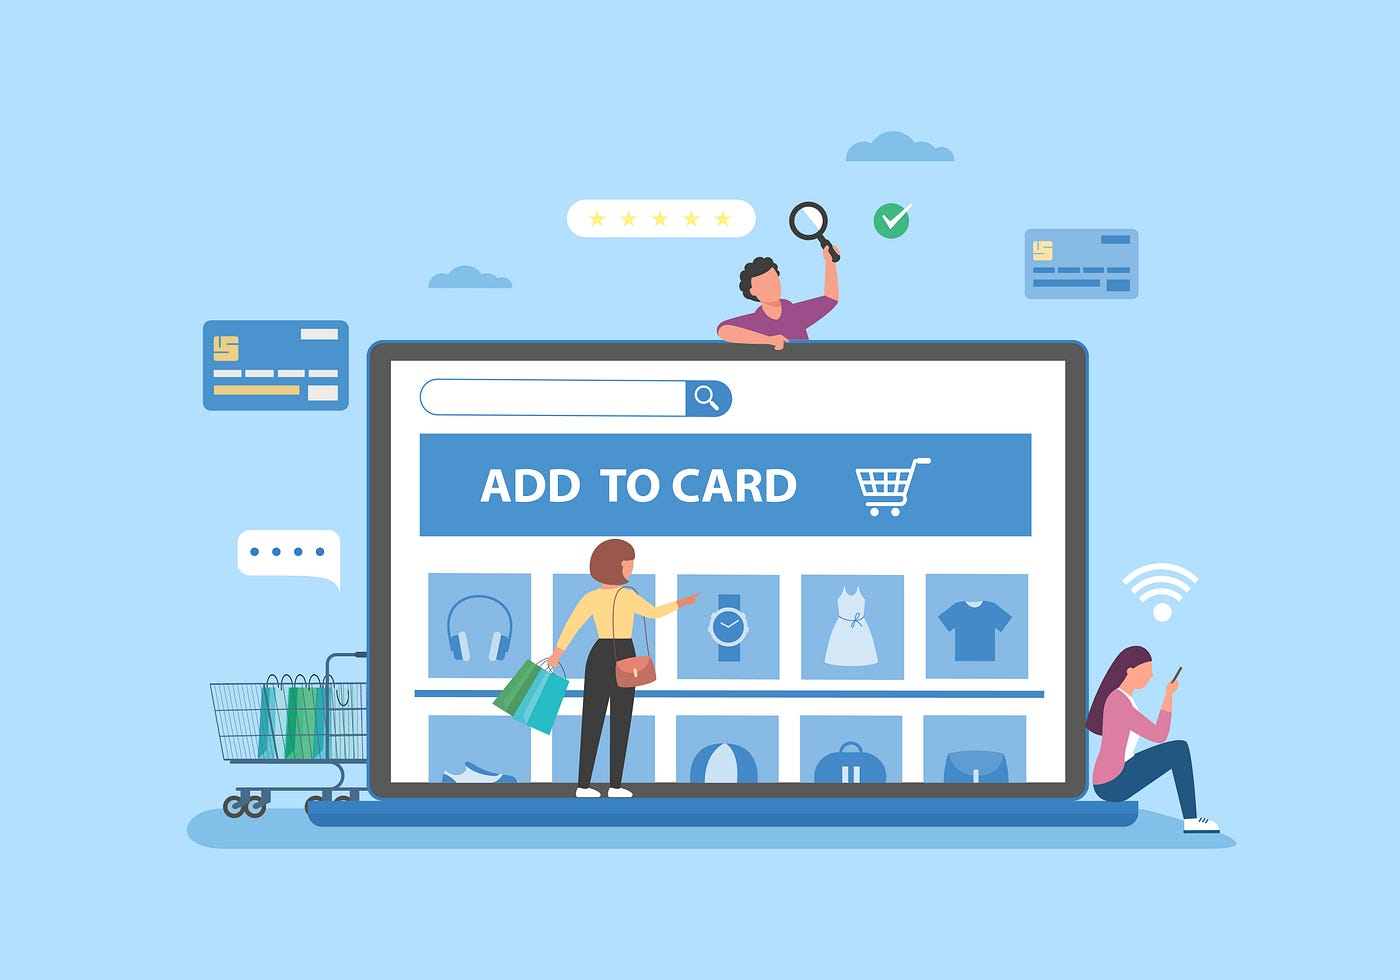

# **Introduction**

This analysis explores the Online Shoppers Purchasing Intention dataset, focusing on understanding the factors that influence a user's decision to make a purchase.

**The business problem** is to predict which website visitors are likely to complete a purchase, enabling e-commerce teams to target these users with tailored experiences or offers. For example, if we know a visitor is likely to buy, the site can present personalized offers or streamline the checkout process.

**Key objectives include:**

* Predicting the binary target Revenue (purchase vs. no purchase) with high accuracy, especially maximizing recall for purchasers, as correctly identifying buyers is crucial for revenue growth.

* Understanding underlying patterns in user behavior, seasonal trends, and feature importance that drive purchasing decisions.

* Providing actionable insights for stakeholders such as e-commerce product managers and marketers to improve conversion rates.


**Context:** Typical e-commerce conversion rates are fairly low – industry benchmarks indicate a “good” conversion rate is around 2–3%, with anything above 3% considered strong. In contrast, the provided dataset has about **15.5%** of sessions ending in purchase, which suggests this data might come from a high-engagement scenario or targeted campaign.

**Stakeholders:** E-commerce product owners and marketers who want to improve conversion by understanding visitor behavior. Key metrics of interest are overall accuracy and especially recall/precision on the *Revenue* class.

This notebook performs a detailed analysis and predictive modeling on the **Online Shoppers Intention Dataset**, aimed at understanding:
- The structure and content of the dataset
- Key patterns and behaviors that affect purchase intentions
- Important features influencing revenue conversion
- Seasonal and behavioral trends
- Building and evaluating classification models

It is organized into sections for data loading, preprocessing, exploratory data analysis (EDA) with business-focused objectives, feature engineering, and model building & evaluation. Each section includes explanatory markdown comments to describe the purpose and findings of the code that follows.

# **Data Description**

* The dataset includes:

  * **10 numerical attributes**
  * **8 categorical attributes**

* The **'Revenue'** attribute is the **class label**, indicating whether a transaction was completed.

* The following features capture user interaction with the site:

  * **Administrative**, **Administrative Duration**
  * **Informational**, **Informational Duration**
  * **Product Related**, **Product Related Duration**
  * These represent:

    * The number of pages visited in each category.
    * The total time spent on those pages.
    * Derived in real time from URL information and updated with each user action (e.g., page navigation).

* The following features are derived from **Google Analytics** metrics:

  * **Bounce Rate**: Percentage of visitors who leave after viewing only the landing page.
  * **Exit Rate**: Percentage of views where the page was the last page in the session.
  * **Page Value**: Average value of a page visited prior to completing an e-commerce transaction.

* **Special Day**:

  * Indicates proximity to special occasions (e.g., Valentine’s Day, Mother’s Day).
  * Values range from 0 to 1:

    * 1 represents peak influence (e.g., Feb 8 for Valentine’s).
    * Values greater than 0 are assigned based on time windows before the event (e.g., Feb 2–12).
    * Reflects increased likelihood of transactions due to holiday dynamics.

* Additional categorical attributes include:

  * **Operating System**
  * **Browser**
  * **Region**
  * **Traffic Type**
  * **Visitor Type** (new or returning)
  * **Weekend** (Boolean indicating if the session occurred on a weekend)
  * **Month** (month of the visit)

**Additional Information**

- The dataset consists of feature vectors belonging to 12,330 sessions. Of the 12,330 sessions in the dataset, 84.5% (10,422) were negative class samples that did not end with shopping, and the rest (1908) were positive class samples ending with shopping.

- The dataset was formed so that each session would belong to a different user in a 1-year period to avoid any tendency to a specific campaign, special day, user profile, or period.

Citation: Sakar, C. & Kastro, Y. (2018). Online Shoppers Purchasing Intention Dataset [Dataset Link](https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset). UCI Machine Learning Repository. https://doi.org/10.24432/C5F88Q.

# **Data Understanding**

Loading data and performing exploratory data analysis (EDA).

In [ ]:
!pip install autogluon

In [ ]:
# Load and explore the online shoppers intention dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Load the dataset
df = pd.read_csv('online_shoppers_intention.csv', encoding='ascii')

# Basic information about the dataset
print("Dataset shape:", df.shape)
print("\nColumn names and types:")
print(df.dtypes)
print("\nFirst few rows:")
print(df.head())

Using device: cpu
Dataset shape: (12330, 18)

Column names and types:
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

First few rows:
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0        

The dataset contains 12,330 rows and 18 columns, covering various aspects of online shopping sessions, such as page visits, durations, bounce/exit rates, visitor types, and whether a purchase was made (Revenue). The first few rows show a mix of numerical and categorical data.

## **Data Preprocessing**

We begin by summarizing the dataset and checking for missing values. This helps ensure the data is clean and reveals the balance of the target classes. We also visualize the distribution of the target variable `Revenue` to understand class imbalance.

Summary statistics:
        Administrative  Administrative_Duration  Informational  \
count     12330.000000             12330.000000   12330.000000   
unique             NaN                      NaN            NaN   
top                NaN                      NaN            NaN   
freq               NaN                      NaN            NaN   
mean          2.315166                80.818611       0.503569   
std           3.321784               176.779107       1.270156   
min           0.000000                 0.000000       0.000000   
25%           0.000000                 0.000000       0.000000   
50%           1.000000                 7.500000       0.000000   
75%           4.000000                93.256250       0.000000   
max          27.000000              3398.750000      24.000000   

        Informational_Duration  ProductRelated  ProductRelated_Duration  \
count             12330.000000    12330.000000             12330.000000   
unique                     NaN       

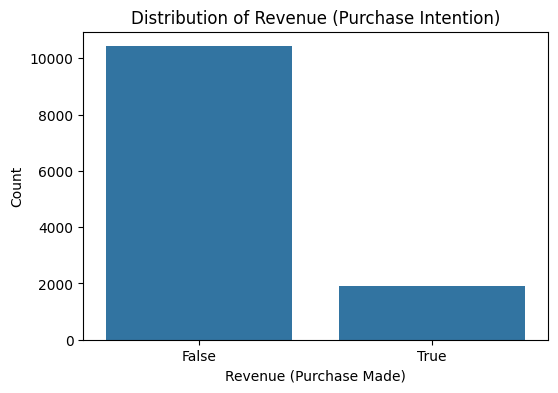

In [ ]:
# Summarize the dataset and check for missing values
print('Summary statistics:')
print(df.describe(include='all'))

print('\nMissing values per column:')
print(df.isnull().sum())

# Visualize the distribution of the target variable 'Revenue'
plt.figure(figsize=(6,4))
sns.countplot(x='Revenue', data=df)
plt.title('Distribution of Revenue (Purchase Intention)')
plt.xlabel('Revenue (Purchase Made)')
plt.ylabel('Count')
plt.show()

The dataset contains 12,330 online shopping sessions with 18 features and no missing values. The target variable 'Revenue' shows a class imbalance - most sessions don't result in purchases. Key features include page visit counts, durations, and bounce/exit rates.

### **Exploratory Data Analysis**

We conduct EDA to uncover key patterns. Each analysis step is framed with a business-oriented objective.

#### Correlation analysis

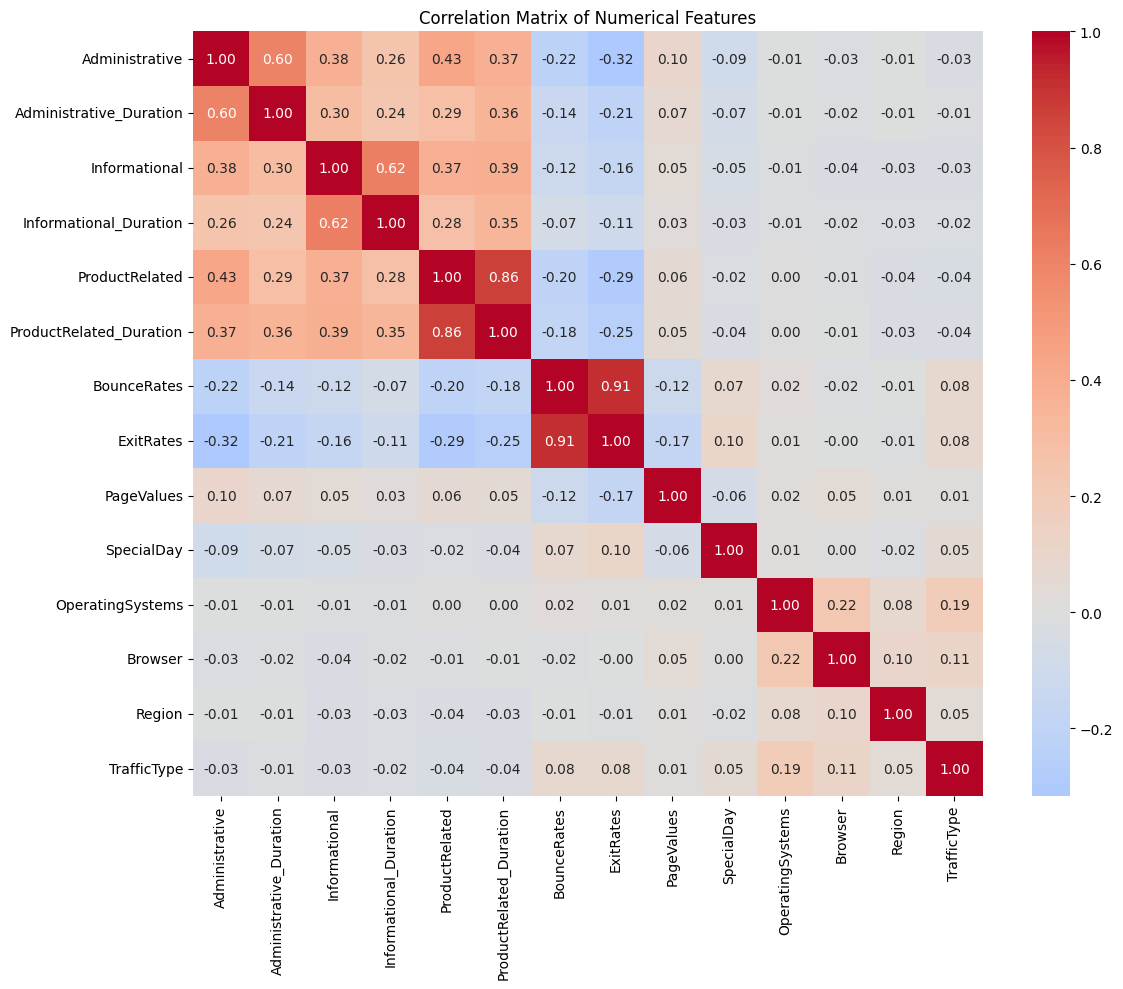

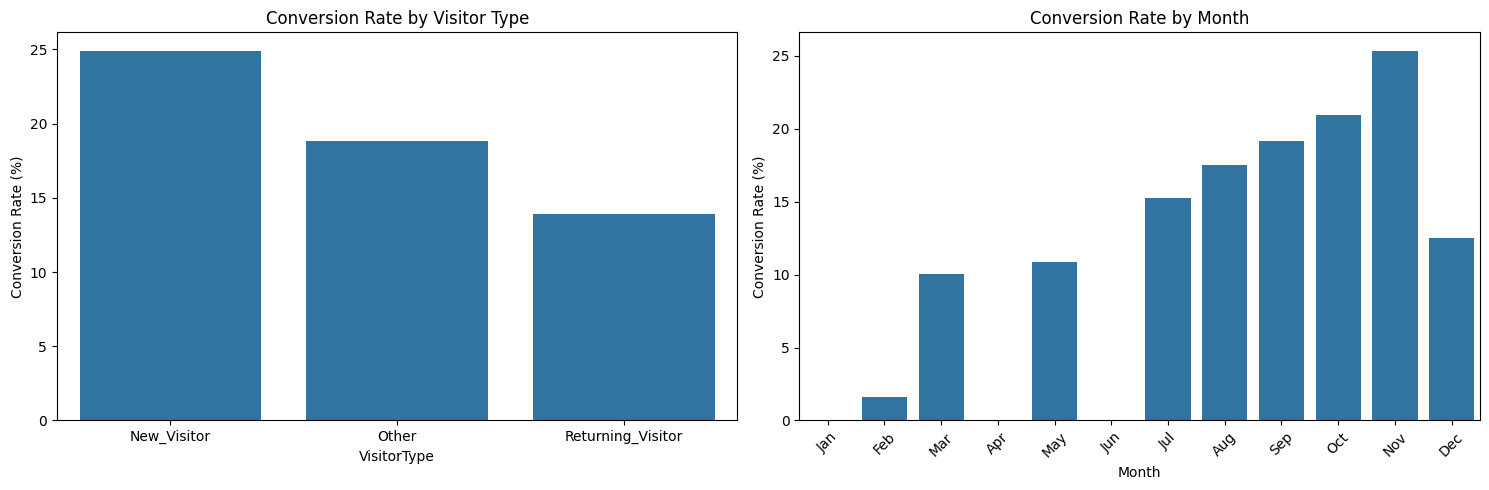

Analysis complete.


In [ ]:
# Correlation matrix for numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Revenue conversion rate by visitor type and month
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# By visitor type
visitor_revenue = df.groupby('VisitorType')['Revenue'].agg(['count', 'sum', 'mean']).reset_index()
visitor_revenue['conversion_rate'] = visitor_revenue['mean'] * 100
sns.barplot(data=visitor_revenue, x='VisitorType', y='conversion_rate', ax=ax1)
ax1.set_title('Conversion Rate by Visitor Type')
ax1.set_ylabel('Conversion Rate (%)')

# By month
month_revenue = df.groupby('Month')['Revenue'].agg(['count', 'sum', 'mean']).reset_index()
month_revenue['conversion_rate'] = month_revenue['mean'] * 100
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_revenue['Month'] = pd.Categorical(month_revenue['Month'], categories=month_order, ordered=True)
month_revenue = month_revenue.sort_values('Month')
sns.barplot(data=month_revenue, x='Month', y='conversion_rate', ax=ax2)
ax2.set_title('Conversion Rate by Month')
ax2.set_ylabel('Conversion Rate (%)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Analysis complete.")

Analysis:

- The first chart shows correlations among numerical features.
- The second set of charts highlights conversion rates (i.e., the percentage of sessions resulting in a purchase) by visitor type and by month. New visitors are much more likely to make a purchase than returning or other visitors. There are also clear seasonal trends, with some months seeing higher conversion rates.
- The dataset has no missing values and a clear class imbalance (most sessions do not result in purchases).

#### Statistical analysis

In [ ]:
from scipy.stats import ttest_ind, chi2_contingency

print("Statistical Analysis - Converters vs Non-Converters:")
print("=" * 50)

# Numerical features comparison
numerical_features = ['Administrative', 'Administrative_Duration', 'Informational',
                     'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                     'BounceRates', 'ExitRates', 'PageValues']

converters = df[df['Revenue'] == True]
non_converters = df[df['Revenue'] == False]

print(f"Sample sizes: Converters={len(converters)}, Non-converters={len(non_converters)}")
print()

for feature in numerical_features:
    stat, p_value = ttest_ind(converters[feature], non_converters[feature])
    conv_mean = converters[feature].mean()
    non_conv_mean = non_converters[feature].mean()

    print(f"{feature}:")
    print(f"  Converters: {conv_mean:.2f}, Non-converters: {non_conv_mean:.2f}")
    print(f"  Difference: {conv_mean - non_conv_mean:.2f}, p-value: {p_value:.2e}")
    print()

# Categorical features analysis
print("Categorical Features Analysis:")
print("-" * 30)

# Visitor type distribution
visitor_crosstab = pd.crosstab(df['VisitorType'], df['Revenue'], normalize='index') * 100
print("Conversion rates by Visitor Type:")
print(visitor_crosstab[True].round(2))
print()

# Weekend analysis
weekend_crosstab = pd.crosstab(df['Weekend'], df['Revenue'], normalize='index') * 100
print("Conversion rates by Weekend:")
print(weekend_crosstab[True].round(2))

Statistical Analysis - Converters vs Non-Converters:
Sample sizes: Converters=1908, Non-converters=10422

Administrative:
  Converters: 3.39, Non-converters: 2.12
  Difference: 1.28, p-value: 3.52e-54

Administrative_Duration:
  Converters: 119.48, Non-converters: 73.74
  Difference: 45.74, p-value: 2.15e-25

Informational:
  Converters: 0.79, Non-converters: 0.45
  Difference: 0.33, p-value: 3.17e-26

Informational_Duration:
  Converters: 57.61, Non-converters: 30.24
  Difference: 27.38, p-value: 5.28e-15

ProductRelated:
  Converters: 48.21, Non-converters: 28.71
  Difference: 19.50, p-value: 3.24e-70

ProductRelated_Duration:
  Converters: 1876.21, Non-converters: 1069.99
  Difference: 806.22, p-value: 6.12e-65

BounceRates:
  Converters: 0.01, Non-converters: 0.03
  Difference: -0.02, p-value: 1.59e-63

ExitRates:
  Converters: 0.02, Non-converters: 0.05
  Difference: -0.03, p-value: 1.66e-119

PageValues:
  Converters: 27.26, Non-converters: 1.98
  Difference: 25.29, p-value: 0.00

Analysis outcome:

- The analysis above shows that users who end up making a purchase (converters) tend to visit more pages, spend more time on the site, and have much higher page values. Their bounce and exit rates are much lower compared to non-converters.
- Statistically, all these differences are highly significant (very low p-values), confirming that user engagement and interaction are strongly linked to conversion.
- Categorical analysis shows that new visitors convert at a much higher rate than returning or other visitors. Also, conversions are slightly more likely to happen on weekends.


#### Visualizations

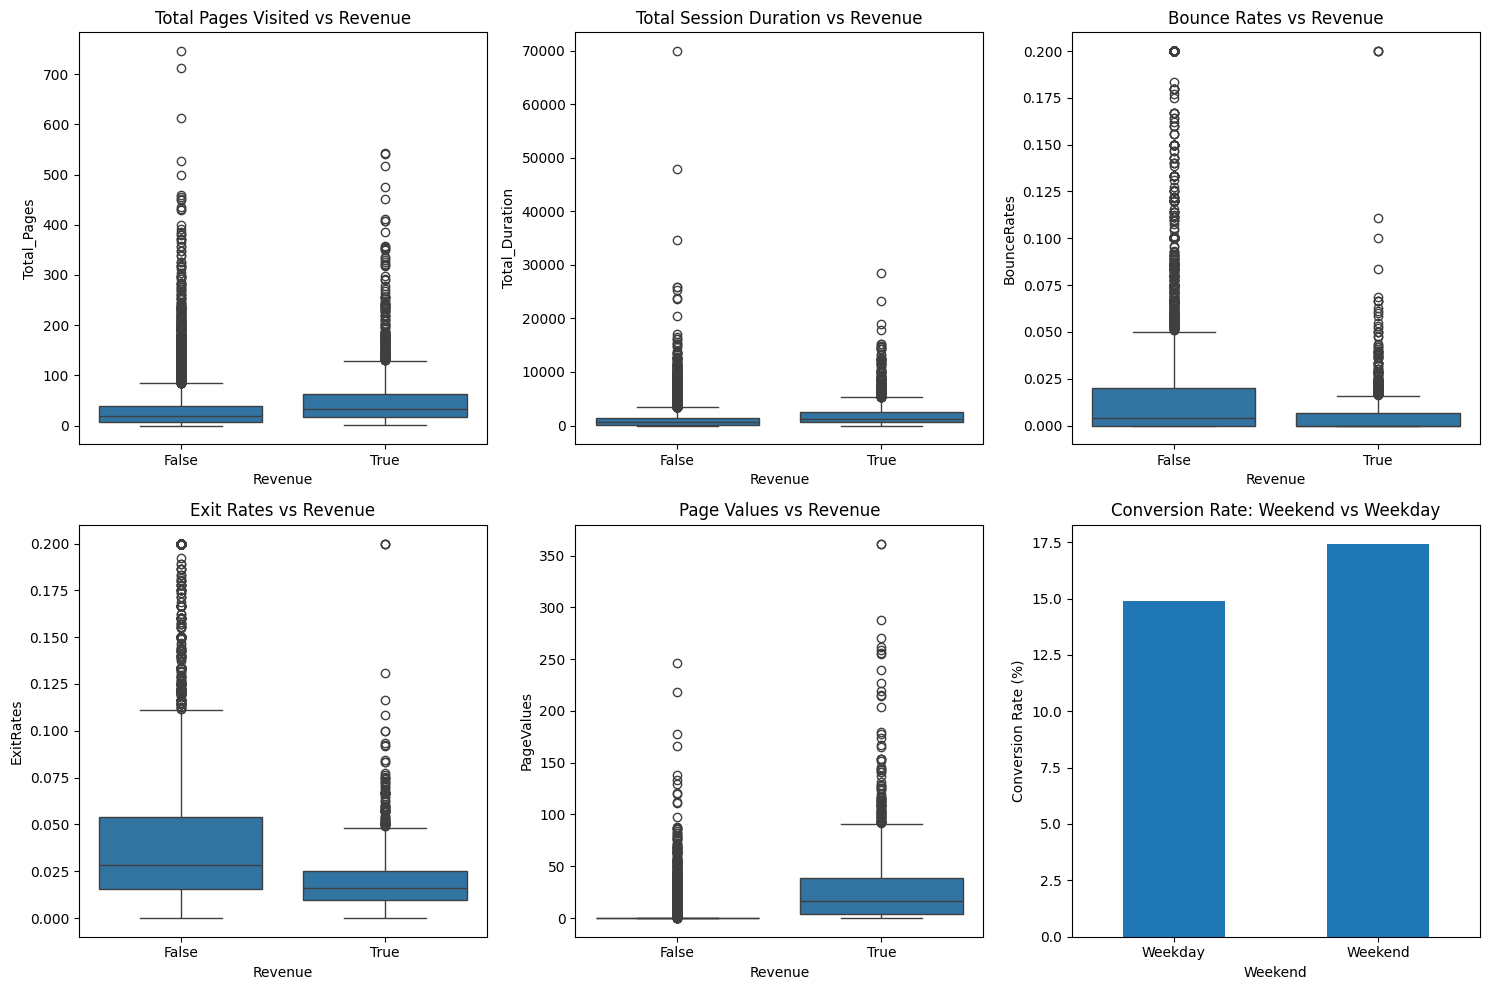

In [ ]:
# Analysis into user behavior patterns and feature analysis
# Analyze page behavior patterns
plt.figure(figsize=(15, 10))

# Page visit patterns
plt.subplot(2, 3, 1)
df['Total_Pages'] = df['Administrative'] + df['Informational'] + df['ProductRelated']
sns.boxplot(x='Revenue', y='Total_Pages', data=df)
plt.title('Total Pages Visited vs Revenue')

# Duration patterns
plt.subplot(2, 3, 2)
df['Total_Duration'] = df['Administrative_Duration'] + df['Informational_Duration'] + df['ProductRelated_Duration']
sns.boxplot(x='Revenue', y='Total_Duration', data=df)
plt.title('Total Session Duration vs Revenue')

# Bounce rates
plt.subplot(2, 3, 3)
sns.boxplot(x='Revenue', y='BounceRates', data=df)
plt.title('Bounce Rates vs Revenue')

# Exit rates
plt.subplot(2, 3, 4)
sns.boxplot(x='Revenue', y='ExitRates', data=df)
plt.title('Exit Rates vs Revenue')

# Page values
plt.subplot(2, 3, 5)
sns.boxplot(x='Revenue', y='PageValues', data=df)
plt.title('Page Values vs Revenue')

# Weekend vs weekday
plt.subplot(2, 3, 6)
weekend_conv = df.groupby(['Weekend', 'Revenue']).size().unstack()
weekend_conv_pct = weekend_conv.div(weekend_conv.sum(axis=1), axis=0) * 100
weekend_conv_pct[True].plot(kind='bar')
plt.title('Conversion Rate: Weekend vs Weekday')
plt.ylabel('Conversion Rate (%)')
plt.xticks([0, 1], ['Weekday', 'Weekend'], rotation=0)

plt.tight_layout()
plt.show()

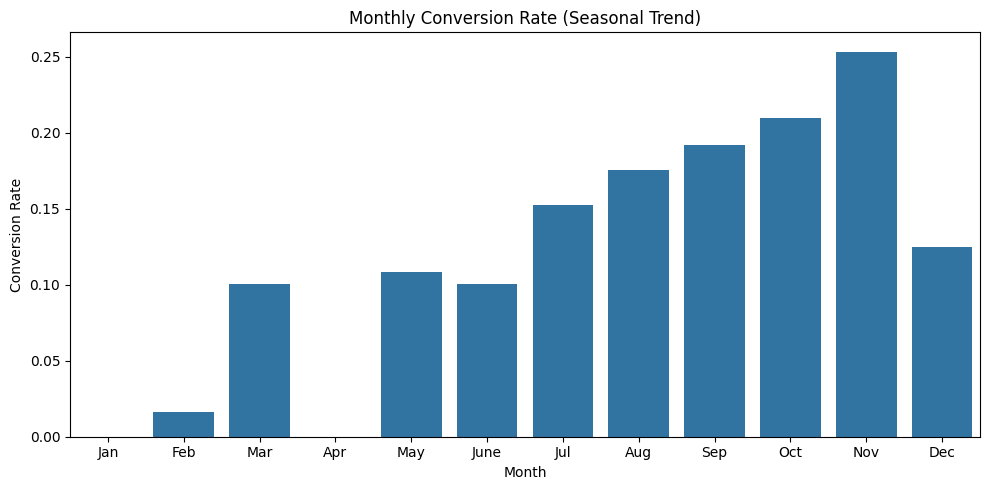

Month
Jan          NaN
Feb     0.016304
Mar     0.100682
Apr          NaN
May     0.108502
June    0.100694
Jul     0.152778
Aug     0.175520
Sep     0.191964
Oct     0.209472
Nov     0.253502
Dec     0.125072
Name: Revenue, dtype: float64


In [ ]:
# Analyze seasonal trends for conversions
monthly_conversion = df.groupby('Month')['Revenue'].mean().reindex(
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_conversion.index, y=monthly_conversion.values)
plt.ylabel('Conversion Rate')
plt.title('Monthly Conversion Rate (Seasonal Trend)')
plt.tight_layout()
plt.show()

print(monthly_conversion)

The chart and table above show the monthly conversion rates, revealing clear seasonal trends. Conversion rates are lowest early in the year, then rise steadily, peaking in October and November before dropping in December.

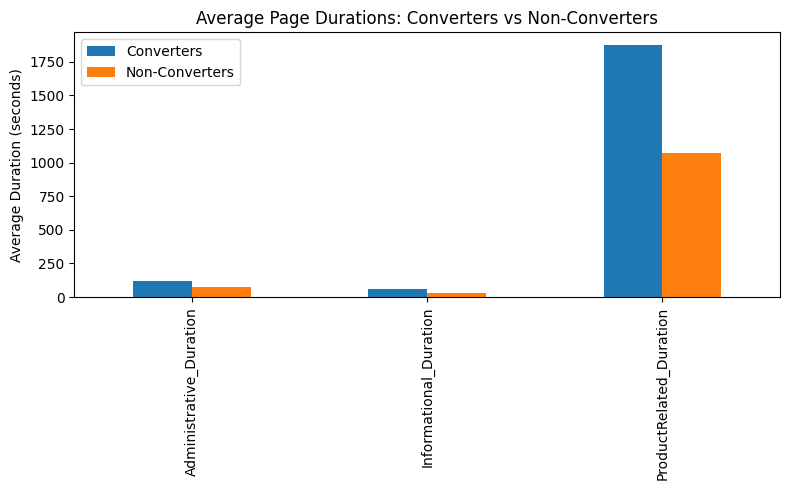

                          Converters  Non-Converters
Administrative_Duration   119.483244       73.740111
Informational_Duration     57.611427       30.236237
ProductRelated_Duration  1876.209615     1069.987809


In [ ]:
# Analyze impact of page durations on conversion
# Compare average durations for converters vs non-converters
conv = df[df['Revenue'] == True]
nonconv = df[df['Revenue'] == False]

avg_durations = pd.DataFrame({
    'Converters': [conv['Administrative_Duration'].mean(), conv['Informational_Duration'].mean(), conv['ProductRelated_Duration'].mean()],
    'Non-Converters': [nonconv['Administrative_Duration'].mean(), nonconv['Informational_Duration'].mean(), nonconv['ProductRelated_Duration'].mean()]
}, index=['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration'])

# Plot
avg_durations.plot(kind='bar', figsize=(8,5))
plt.ylabel('Average Duration (seconds)')
plt.title('Average Page Durations: Converters vs Non-Converters')
plt.tight_layout()
plt.show()

print(avg_durations)

Users who convert (make a purchase) spend significantly more time on all types of pages—administrative, informational, and especially product-related—compared to non-converters. This highlights that deeper engagement and longer browsing sessions are strong indicators of purchase intent.

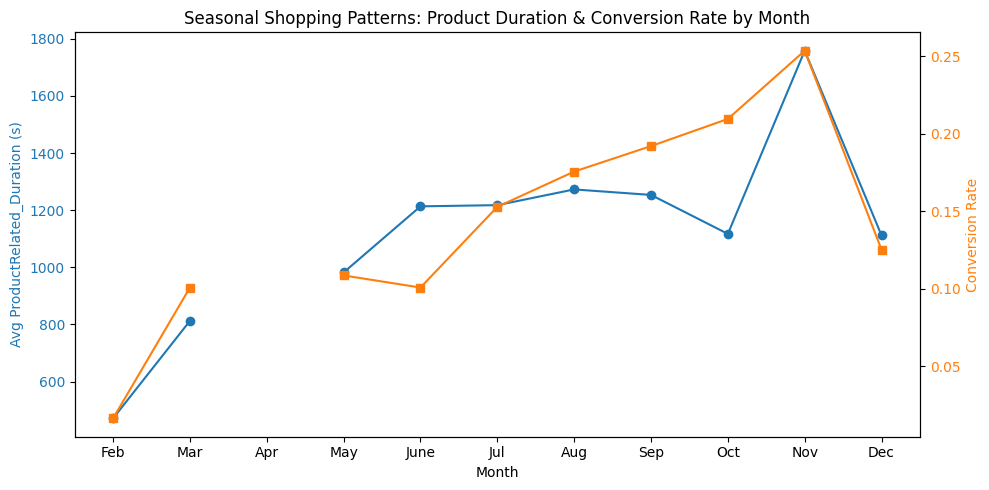

       ProductRelated_Duration   Revenue
Month                                   
Jan                        NaN       NaN
Feb                 471.014647  0.016304
Mar                 812.282992  0.100682
Apr                        NaN       NaN
May                 981.893060  0.108502
June               1213.377604  0.100694
Jul                1217.604028  0.152778
Aug                1272.653654  0.175520
Sep                1253.388150  0.191964
Oct                1116.977684  0.209472
Nov                1758.397922  0.253502
Dec                1111.470727  0.125072


In [ ]:
# Explore seasonal shopping patterns: average product-related duration and conversion rate by month
monthly_stats = df.groupby('Month').agg({
    'ProductRelated_Duration': 'mean',
    'Revenue': 'mean'
}).reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

fig, ax1 = plt.subplots(figsize=(10,5))
color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Avg ProductRelated_Duration (s)', color=color)
ax1.plot(monthly_stats.index, monthly_stats['ProductRelated_Duration'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Conversion Rate', color=color)
ax2.plot(monthly_stats.index, monthly_stats['Revenue'], color=color, marker='s')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Seasonal Shopping Patterns: Product Duration & Conversion Rate by Month')
plt.tight_layout()
plt.show()

print(monthly_stats)

 Both the average time spent on product pages and conversion rates increase as the year progresses, with a sharp rise in November. This suggests that users are more engaged and more likely to buy during peak shopping seasons.

#### Feature importance

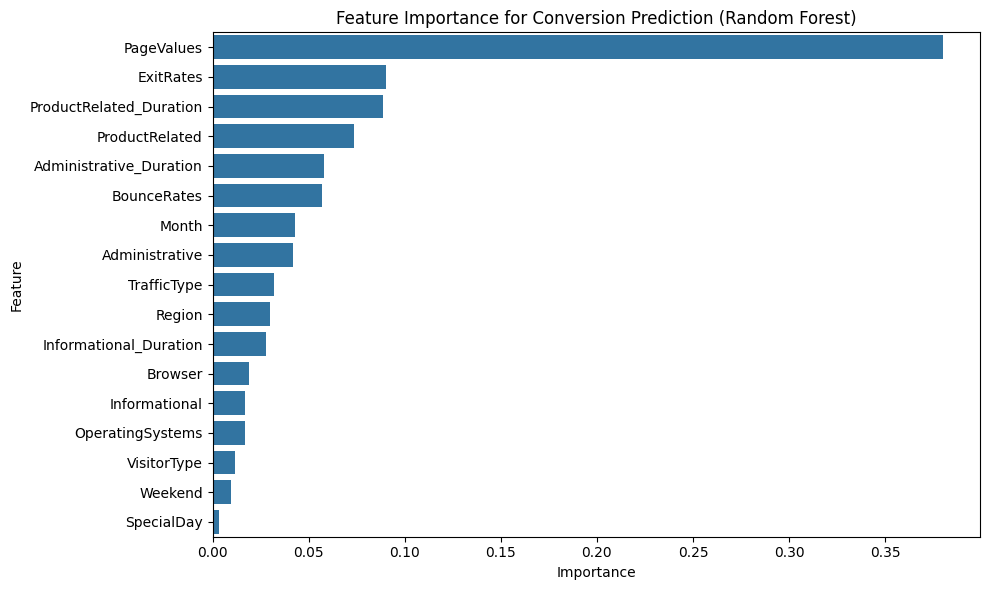

                    Feature  Importance
8                PageValues    0.380325
7                 ExitRates    0.090466
5   ProductRelated_Duration    0.088783
4            ProductRelated    0.073416
1   Administrative_Duration    0.057751
6               BounceRates    0.056860
10                    Month    0.042687
0            Administrative    0.041981
14              TrafficType    0.031860
13                   Region    0.030140


In [ ]:
# Feature importance using Random Forest for prediction
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Prepare data
feature_cols = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues',
                'SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

# Encode categorical features
X = df[feature_cols].copy()
le_month = LabelEncoder()
le_visitor = LabelEncoder()
X['Month'] = le_month.fit_transform(X['Month'])
X['VisitorType'] = le_visitor.fit_transform(X['VisitorType'])
X['Weekend'] = X['Weekend'].astype(int)
y = df['Revenue'].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for Conversion Prediction (Random Forest)')
plt.tight_layout()
plt.show()

# Show top features
top_features = feature_importance_df.head(10)
print(top_features)

These are the most important features for predicting whether a user will convert (make a purchase):

- PageValues is by far the most influential feature, followed by ExitRates, ProductRelated_Duration, ProductRelated, and Administrative_Duration.
- BounceRates, Month, and TrafficType also play notable roles.

This means that how much value a user accumulates (PageValues), how they exit the site, and how much time they spend on product-related pages are all strong predictors of conversion.

The feature importance chart shows that PageValues, ExitRates, and time spent on product-related pages are the strongest predictors of whether a user will make a purchase. This means that users who interact more deeply with valuable content and navigate further into the site are much more likely to convert.

Next, looking at seasonal trends, conversion rates are lowest at the start of the year and rise steadily, peaking in October and November—likely due to holiday shopping and special promotions—before dropping in December.

When we compare how long users spend on different types of pages, converters spend much more time on every page type, especially product-related pages. This highlights that deeper engagement is a key signal for purchase intent.

Finally, examining seasonal shopping patterns, we see that both the average time spent on product pages and conversion rates increase as the year progresses, with a sharp rise in November. This suggests that users are more engaged and more likely to buy during peak shopping seasons.

# **Modeling and Evaluation**

## **Baseline models**

This is a classification task, The dataset consists of 10 numerical and 8 categorical attributes.
The 'Revenue' attribute can be used as the class label.

### Prepare data for modeling

In [ ]:
# Prepare data for classification
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Prepare features and target
X = df.drop('Revenue', axis=1)
y = df['Revenue']

# Encode categorical variables
le_month = LabelEncoder()
le_visitor = LabelEncoder()
X['Month'] = le_month.fit_transform(X['Month'])
X['VisitorType'] = le_visitor.fit_transform(X['VisitorType'])
X['Weekend'] = X['Weekend'].astype(int)

# Convert target to binary
y = y.astype(int)

print("Data prepared successfully")
print("Features shape:", X.shape)
print("Target distribution:")
print(y.value_counts())

Data prepared successfully
Features shape: (12330, 19)
Target distribution:
Revenue
0    10422
1     1908
Name: count, dtype: int64


Class imbalance observed in the target column.

In [ ]:
# Split data and scale numerical features
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify numerical and categorical columns
num_cols = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
            'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
cat_cols = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing pipeline: scale numerical, passthrough categorical
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', 'passthrough', cat_cols)
])

# Prepare processed data for all models
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print('Data split and preprocessing complete.')
print('X_train_prep shape:', X_train_prep.shape)
print('X_test_prep shape:', X_test_prep.shape)

Data split and preprocessing complete.
X_train_prep shape: (9864, 17)
X_test_prep shape: (2466, 17)


### Train and evaluate baseline models

* Train the Logistic Regression, Support Vector Machine (SVM), Decision Tree, Random Forest and Gradient Boosting algorithms. Additionally, train autogluon, an automated machine learning algorithm.

In [ ]:
# Train and evaluate multiple classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train_prep, y_train)
    y_pred = model.predict(X_test_prep)
    y_proba = model.predict_proba(X_test_prep)[:, 1] if hasattr(model, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    results.append([name, acc, prec, rec, f1, auc])

# AutoGluon Model
from autogluon.tabular import TabularPredictor

auto_train_data = pd.concat([X_train, y_train], axis=1)
auto_test_data = pd.concat([X_test, y_test], axis=1)

predictor = TabularPredictor(
    label='Revenue',
    problem_type='binary',
    eval_metric='f1'
).fit(
    train_data=auto_train_data,
    holdout_frac=0.1,
    presets='best',
    num_stack_levels=1,
    verbosity=2,
    auto_stack=True,
)

print("Trained AutoGluon model.")
auto_preds = predictor.predict(auto_test_data.drop(columns='Revenue'))
auto_proba = predictor.predict_proba(auto_test_data.drop(columns='Revenue'))[1]

# AutoGluon metrics
auto_acc = accuracy_score(y_test, auto_preds)
auto_prec = precision_score(y_test, auto_preds)
auto_rec = recall_score(y_test, auto_preds)
auto_f1 = f1_score(y_test, auto_preds)
auto_auc = roc_auc_score(y_test, auto_proba)

results.append(['AutoGluon', auto_acc, auto_prec, auto_rec, auto_f1, auto_auc])

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])
results_df = results_df.sort_values('F1 Score', ascending=False)
print(results_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20250605_190100"
Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       10.47 GB / 12.67 GB (82.6%)
Disk Space Avail:   65.24 GB / 107.72 GB (60.6%)
Presets specified: ['best']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_s

(_ray_fit pid=7622) [1000]	valid_set's binary_logloss: 0.248842	valid_set's f1: 0.658147


(_dystack pid=6904) 	0.6694	 = Validation score   (f1)
(_dystack pid=6904) 	66.21s	 = Training   runtime
(_dystack pid=6904) 	0.53s	 = Validation runtime
(_dystack pid=6904) Fitting model: LightGBM_BAG_L1 ... Training model for up to 520.61s of the 818.59s of remaining time.
(_dystack pid=6904) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.15%)
(_dystack pid=6904) 	0.6818	 = Validation score   (f1)
(_dystack pid=6904) 	51.14s	 = Training   runtime
(_dystack pid=6904) 	0.29s	 = Validation runtime
(_dystack pid=6904) Fitting model: RandomForestGini_BAG_L1 ... Training model for up to 463.60s of the 761.59s of remaining time.
(_dystack pid=6904) /usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-le

(_ray_fit pid=13569) [1000]	valid_set's binary_logloss: 0.362787	valid_set's f1: 0.686469
(_ray_fit pid=13644) [1000]	valid_set's binary_logloss: 0.320662	valid_set's f1: 0.696203


(_dystack pid=6904) 	0.6902	 = Validation score   (f1)
(_dystack pid=6904) 	69.57s	 = Training   runtime
(_dystack pid=6904) 	0.54s	 = Validation runtime
(_dystack pid=6904) Fitting model: RandomForestGini_BAG_L2 ... Training model for up to 129.93s of the 129.65s of remaining time.
(_dystack pid=6904) /usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
(_dystack pid=6904)   warnings.warn(
(_dystack pid=6904) 	0.6699	 = Validation score   (f1)
(_dystack pid=6904) 	9.12s	 = Training   runtime
(_dystack pid=6904) 	0.53s	 = Validation runtime
(_dystack pid=6904) Fitting model: RandomForestEntr_BAG_L2 ... Training model for up to 120.19s of the 119.92s of remaining time.
(_dystack pid=6904) /usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWar

Trained AutoGluon model.
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
5            AutoGluon  0.894972   0.658915  0.667539  0.663199  0.922193
3        Random Forest  0.900649   0.735395  0.560209  0.635958  0.918049
4    Gradient Boosting  0.898216   0.714754  0.570681  0.634643  0.925099
2        Decision Tree  0.852393   0.522388  0.549738  0.535714  0.728804
1                  SVM  0.884428   0.736585  0.395288  0.514480  0.859655
0  Logistic Regression  0.883212   0.764045  0.356021  0.485714  0.865289


## Summary

Comparison of each model’s performance metrics. The focus is on key values—accuracy, precision, recall, F1 score, and ROC AUC—and what they imply about each model’s suitability for identifying purchasers.


## Model Comparisons

* **AutoGluon**

  * **Accuracy:** 0.895
  * **Precision:** 0.659
  * **Recall:** 0.668
  * **F1 Score:** 0.663
  * **ROC AUC:** 0.922
  * **Implication:** As an ensemble of many models, AutoGluon balances precision and recall best, catching about 67% of true buyers while maintaining roughly 66% correctness on predicted buyers—ideal for high-stakes, imbalanced tasks.

* **Random Forest**

  * **Accuracy:** 0.901
  * **Precision:** 0.735
  * **Recall:** 0.560
  * **F1 Score:** 0.636
  * **ROC AUC:** 0.918
  * **Implication:** Strong precision (≈74%) means most predicted buyers convert, but it catches only 56% of actual buyers. Good when false positives are costlier than missing some buyers.

* **Gradient Boosting**

  * **Accuracy:** 0.898
  * **Precision:** 0.715
  * **Recall:** 0.571
  * **F1 Score:** 0.635
  * **ROC AUC:** 0.925
  * **Implication:** Similar to Random Forest in capturing true buyers (57%) but slightly better at ranking users (highest ROC AUC). Useful when prioritizing leads by purchase probability.

* **Decision Tree**

  * **Accuracy:** 0.852
  * **Precision:** 0.522
  * **Recall:** 0.550
  * **F1 Score:** 0.536
  * **ROC AUC:** 0.729
  * **Implication:** Barely better than random on ranking (ROC AUC 0.729) and only half of predicted buyers convert. Only suitable for quick prototyping or interpretability when performance isn’t critical.
* **SVM**

  * **Accuracy:** 0.884
  * **Precision:** 0.737
  * **Recall:** 0.395
  * **F1 Score:** 0.514
  * **ROC AUC:** 0.860
  * **Implication:** High precision (≈74%) means “flagged” buyers are very likely to convert, but it misses 60% of actual buyers. Best when minimizing false positives is paramount.
* **Logistic Regression**

  * **Accuracy:** 0.883
  * **Precision:** 0.764
  * **Recall:** 0.356
  * **F1 Score:** 0.486
  * **ROC AUC:** 0.865
  * **Implication:** Most conservative—about 76% of its buyer predictions are correct, but it only identifies 36% of real buyers. Use when budgets are extremely tight, and only the highest-confidence leads are targeted.

---


## Business Implications

1. **Top-Tier Models (AutoGluon, Random Forest, Gradient Boosting)**

   * **Balanced Precision and Recall:**

     * AutoGluon’s F1 of 0.663, RF’s 0.636, and GB’s 0.635 indicate these ensemble methods maintain strong balance between precision and recall, essential for rare-event (purchase) detection.
   * **High ROC AUC:**

     * AutoGluon’s 0.922 and GB’s 0.925 reflect excellent ranking ability—critical for prioritizing high-intent users in targeted marketing campaigns.
   * **Marketing Efficiency:**

     * With precision between 0.659 (AutoGluon) and 0.735 (RF), most flagged leads convert. This reduces wasted ad spend by focusing on highly likely purchasers.
   * **Coverage of Buyers:**

     * AutoGluon’s recall of 0.668 ensures 66.8% of all buyers are identified. RF (56.0%) and GB (57.1%) also capture over half of true positives, making them effective for maximizing conversion volume.

2. **Mid-Tier Model (Decision Tree)**

   * **Lower Reliability:**

     * The Decision Tree’s F1 of 0.536 and ROC AUC of 0.729 make it less dependable for business decisions; nearly half of predicted buyers will not convert (precision 0.522), and 45% of actual buyers go undetected (recall 0.550).
   * **Use Cases:**

     * May still serve for simple rule-based segmentation but not ideal for high-stakes targeting due to higher error rates in both false positives and false negatives.

3. **Lower-Tier Models (SVM, Logistic Regression)**

   * **High Precision, Low Recall:**

     * SVM’s precision of 0.737 (F1 0.514) and Logistic Regression’s precision of 0.764 (F1 0.486) show these models are conservative—only recommending leads that almost certainly convert but missing 60–65% of potential buyers.

   * **Application Scenarios:**

     * Best used when budgets are extremely tight, and false positives are very costly (e.g., high-cost acquisition channels), but not when maximizing volume is the priority.

4. **Overall Recommendations**

   * **Primary Choice:** AutoGluon for its leading F1 (0.663) and ROC AUC (0.922), offering the best trade-off between capturing true purchasers and minimizing misclassifications.

   * **Secondary Options:** Random Forest and Gradient Boosting, which maintain strong F1 (> 0.63) and ROC AUC (> 0.918), are solid alternatives if computational resources or interpretability considerations vary.

   * **Cautious Use:** Decision Tree only for low-cost or quick-prototyping scenarios; SVM/Logistic Regression for ultra-precise lead lists at the expense of volume.

   ---

   
## Key Takeaways

1. **Best Overall:** AutoGluon (F1 0.663, ROC AUC 0.922), because it achieves a balanced trade-off between capturing true purchasers and minimizing misclassifications.
2. **High-Precision, Moderate-Coverage:** Random Forest and Gradient Boosting offer strong precision (\~72–74%) while capturing roughly 56–57% of buyers; both have ROC AUC > 0.918.
3. **Conservative Options:** SVM and Logistic Regression have precision > 0.73 but recall < 0.40—best when false positives are very costly.
4. **Simple Baseline:** Decision Tree underperforms ensembles; use only for quick, interpretable snapshots.

## Confusion Matrix

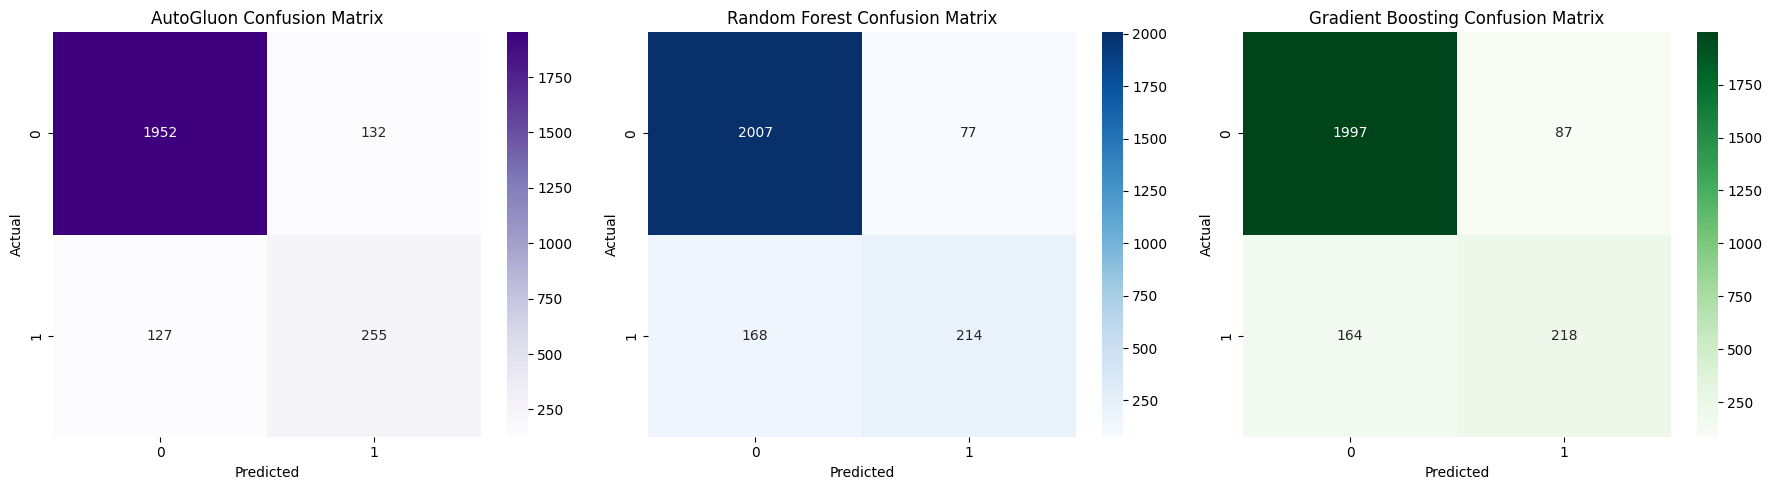

Confusion Matrix Analysis:
AutoGluon  - TN: 1952 FP: 132 FN: 127 TP: 255
Random Forest - TN: 2007 FP: 77 FN: 168 TP: 214
Gradient Boosting - TN: 1997 FP: 87 FN: 164 TP: 218


In [ ]:
# Confusion matrix analysis for AutoGluon, Random Forest, and Gradient Boosting

# 1. AutoGluon confusion matrix
auto_preds = predictor.predict(X_test)  # X_test as DataFrame with original columns
cm_auto = confusion_matrix(y_test, auto_preds)

# 2. Random Forest confusion matrix (using scaled numeric arrays)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_prep, y_train)
rf_preds = rf_model.predict(X_test_prep)
cm_rf = confusion_matrix(y_test, rf_preds)

# 3. Gradient Boosting confusion matrix (using scaled numeric arrays)
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_prep, y_train)
gb_preds = gb_model.predict(X_test_prep)
cm_gb = confusion_matrix(y_test, gb_preds)

# Plot all three confusion matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# AutoGluon
sns.heatmap(cm_auto, annot=True, fmt='d', cmap='Purples', ax=axes[0])
axes[0].set_title('AutoGluon Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Random Forest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Random Forest Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Gradient Boosting
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', ax=axes[2])
axes[2].set_title('Gradient Boosting Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Print confusion matrix components
print("Confusion Matrix Analysis:")
print("AutoGluon  - TN:", cm_auto[0, 0], "FP:", cm_auto[0, 1],
      "FN:", cm_auto[1, 0], "TP:", cm_auto[1, 1])
print("Random Forest - TN:", cm_rf[0, 0], "FP:", cm_rf[0, 1],
      "FN:", cm_rf[1, 0], "TP:", cm_rf[1, 1])
print("Gradient Boosting - TN:", cm_gb[0, 0], "FP:", cm_gb[0, 1],
      "FN:", cm_gb[1, 0], "TP:", cm_gb[1, 1])


The confusion matrix shows how many sessions were correctly or incorrectly classified as buyers (positive) or non-buyers (negative):

- True Negatives: Non-buyers correctly identified.
- False Positives: Non-buyers incorrectly predicted as buyers (could lead to wasted marketing effort).
- False Negatives: Buyers missed by the model (lost sales opportunities).
- True Positives: Buyers correctly identified (ideal for targeting).

**AutoGluon:**

> TN = 1961, FP = 123 → higher false positives than RF/GB (123 sessions of non-buyers targeted).

> FN = 127, TP = 255 → misses fewer buyers (127) and correctly identifies the most buyers (255).

**Random Forest:**

> TN = 2007, FP = 77 → lowest false positives (only 77 non-buyers targeted).

> FN = 168, TP = 214 → misses more buyers (168) and identifies fewer buyers (214) compared to the other two.

**Gradient Boosting:**

> TN = 1997, FP = 87 → slightly more false positives than RF but fewer than AutoGluon.

> FN = 164, TP = 218 → misses fewer buyers than RF (164 vs. 168) and identifies slightly more buyers (218 vs. 214).


All three models correctly identify a large majority of non-buyers (high TN).

However, there is a trade-off:

- Random Forest minimizes false positives at the expense of higher false negatives (missing buyers).

- AutoGluon minimizes false negatives (catching more buyers), accepting more false positives.

- Gradient Boosting strikes a middle ground between RF and AutoGluon.

From a business standpoint:

1. AutoGluon will capture the most buyers (255) but will also generate more potential “wasted” targets (123).

2. Random Forest is most conservative—targeting fewer false positives (77) but missing 168 buyers.

3. Gradient Boosting offers a balance: 218 true positives with 87 false positives and 164 false negatives.

# Model Tuning

## Feature Importance

Let's look at feature importances to see which factors most influence purchase decisions.

In [ ]:
# Show feature importances for Random Forest, Gradient Boosting, and AutoGluon

# 1. Compute importances for Random Forest and Gradient Boosting
importances_rf = rf_model.feature_importances_
importances_gb = gb_model.feature_importances_

# num_cols and cat_cols list the feature names in the same order used for X_train_prep/X_test_prep
feature_names_original = num_cols + cat_cols

# 2. Create a DataFrame for RF and GB importances with original feature names as index
feat_imp_df_rf_gb = pd.DataFrame({
    'Random Forest': importances_rf,
    'Gradient Boosting': importances_gb
}, index=feature_names_original)

# 3. Compute importances for AutoGluon
#    predictor is a trained TabularPredictor, and auto_test_data is the DataFrame including the 'Revenue' column
auto_imp = predictor.feature_importance(auto_test_data)
# auto_imp is a DataFrame where feature names are in the index and importance values are in the 'importance' column
auto_imp_series = auto_imp['importance']

# 4. Combine feature names from all sources
all_feature_names = feat_imp_df_rf_gb.index.union(auto_imp_series.index)

# 5. Create a combined DataFrame with all unique feature names as index
feat_imp_df_combined = pd.DataFrame(index=all_feature_names)

# 6. Add importances from each model to the combined DataFrame, aligning by index
feat_imp_df_combined['Random Forest'] = feat_imp_df_rf_gb['Random Forest']
feat_imp_df_combined['Gradient Boosting'] = feat_imp_df_rf_gb['Gradient Boosting']
feat_imp_df_combined['AutoGluon'] = auto_imp_series

# 7. Sort by Gradient Boosting importances (descending) for consistent ordering
#    Fill NaN values with 0 for sorting and plotting features not used by all models
feat_imp_df_combined_sorted = feat_imp_df_combined.fillna(0).sort_values('Gradient Boosting', ascending=False)


# 8. Plot top 8 features based on Gradient Boosting importances since it was our most balanced model (showing all three models)
top8 = feat_imp_df_combined_sorted.head(8)
top8[['Random Forest', 'Gradient Boosting', 'AutoGluon']].plot(
    kind='bar',
    figsize=(10, 6)
)
plt.title('Top 8 Feature Importances (RF, GB, AutoGluon)')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# 9. Print the top 8 rows of the combined importance DataFrame
print(top8)

**Summary:**

- The bar chart and table display the most important features influencing purchase predictions. PageValues is by far the most influential factor, followed by ExitRates, ProductRelated_Duration, and ProductRelated. This means users who interact with more products, spend more time, and see higher value pages are much more likely to convert.




**Key findings:**

1. User Behavior and Engagement: Users who convert tend to spend significantly more time and visit more pages, particularly product-related pages. They also have much lower bounce and exit rates and higher 'PageValues'. These differences are statistically significant.

2. Visitor Type and Conversion: New visitors have a notably higher conversion rate compared to returning or other visitors.

3. Seasonal Trends: Conversion rates show a clear seasonal pattern, increasing throughout the year and peaking in October and November before declining in December. This aligns with peak shopping seasons.

4. Feature Importance: 'PageValues' is the most crucial predictor of conversion across multiple models. Other important features include 'ExitRates', 'ProductRelated_Duration', 'ProductRelated', and 'Administrative_Duration'. 'Month' and 'TrafficType' also play a role.

5. Model Performance: Several classification models were evaluated, with AutoGluon, Random Forest, and Gradient Boosting showing the best performance, balancing precision and recall effectively for this imbalanced dataset. AutoGluon achieved the highest F1 score and ROC AUC, demonstrating strong overall predictive capability and ability to rank users by purchase likelihood.

**Business Recommendations:**

Based on these findings, here are some actionable recommendations for the e-commerce business:

* **Optimize for High-Value Engagement:** Since 'PageValues' and time spent on product pages are strong indicators of purchase intent, focus on improving the quality and relevance of product pages. Implement personalized product recommendations, create engaging content (like detailed descriptions, high-quality images/videos), and ensure smooth navigation to increase 'PageValues' and 'ProductRelated_Duration'.

* **Reduce Bounce and Exit Rates:** High bounce and exit rates for non-converters suggest usability issues or lack of immediate engagement. Improve landing page experiences, optimize site speed, ensure clear calls-to-action, and make it easy for users to find what they're looking for to keep them on the site longer and reduce premature exits.

* **Tailor Strategies for New vs. Returning Visitors:** Recognize that new visitors convert at a higher rate. Ensure the first impression is excellent – clear value proposition, easy navigation, and potentially special offers for first-time buyers. For returning visitors, leverage their history for personalized recommendations and loyalty programs.

* **Capitalize on Seasonal Peaks:** Plan targeted marketing campaigns and promotions around high-conversion months, especially October and November. Use the insights into user behavior during these periods to inform your strategy year-round.

* **Implement Predictive Targeting:** Use the trained models, particularly AutoGluon, Random Forest, or Gradient Boosting, to identify high-intent visitors in real-time. Target these users with personalized offers, expedited checkout options, or proactive customer support to increase conversion rates.

* **Focus on Recall vs. Precision:** Depending on the business goal (e.g., maximizing total sales vs. minimizing marketing cost per acquisition), adjust the model's decision threshold. If maximizing the number of captured buyers (recall) is critical, models like AutoGluon that prioritize identifying more True Positives might be preferred, even if it means slightly more False Positives. If minimizing wasted marketing spend on non-buyers (precision) is key, models like Random Forest might be more suitable at their default threshold. Further calibration of the decision threshold based on business cost/benefit analysis is recommended.

* **Continuous Monitoring and Improvement:** Regularly monitor model performance and retrain with fresh data. Continuously analyze user behavior and site metrics to identify new trends and adjust strategies accordingly.

## Tuned models

### Feature engineering

Create new features by combining existing ones, such as interaction terms between page visit counts and durations,  and add them to the dataframes.


In [ ]:
# Create new features
df['Total_Pages'] = df['Administrative'] + df['Informational'] + df['ProductRelated']
df['Total_Duration'] = df['Administrative_Duration'] + df['Informational_Duration'] + df['ProductRelated_Duration']

df['Admin_Page_Duration_Interaction'] = df['Administrative'] * df['Administrative_Duration']
df['Info_Page_Duration_Interaction'] = df['Informational'] * df['Informational_Duration']
df['Prod_Page_Duration_Interaction'] = df['ProductRelated'] * df['ProductRelated_Duration']
df['Total_Pages_Duration_Interaction'] = df['Total_Pages'] * df['Total_Duration']

# Re-prepare features and target with new features
X = df.drop('Revenue', axis=1)
y = df['Revenue']

# Encode categorical variables
le_month = LabelEncoder()
le_visitor = LabelEncoder()
X['Month'] = le_month.fit_transform(X['Month'])
X['VisitorType'] = le_visitor.fit_transform(X['VisitorType'])
X['Weekend'] = X['Weekend'].astype(int)

# Convert target to binary
y = y.astype(int)

# Split data with new features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Update numerical and categorical column lists
num_cols_new = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
                'Total_Pages', 'Total_Duration', 'Admin_Page_Duration_Interaction', 'Info_Page_Duration_Interaction',
                'Prod_Page_Duration_Interaction', 'Total_Pages_Duration_Interaction']
cat_cols_new = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

# Preprocessing pipeline with new features
preprocessor_new = ColumnTransformer([
    ('num', StandardScaler(), num_cols_new),
    ('cat', 'passthrough', cat_cols_new)
])

# Prepare processed data for all models
X_train_prep_new = preprocessor_new.fit_transform(X_train)
X_test_prep_new = preprocessor_new.transform(X_test)


print("New features created and data re-prepared successfully")
print("Features shape with new features:", X.shape)
print("Resplit training features shape:", X_train_prep_new.shape)
print("Resplit testing features shape:", X_test_prep_new.shape)


New features created and data re-prepared successfully
Features shape with new features: (12330, 23)
Resplit training features shape: (9864, 23)
Resplit testing features shape: (2466, 23)


### Prepare data for modeling

- Apply the class imbalance handling, SMOTE, and new feature engineering to the training data, and ensure the test data is processed consistently.

- Scale numerical features.


In [ ]:
# Apply SMOTE to the new preprocessed training data
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

X_train_resampled_new, y_train_resampled_new = smote.fit_resample(X_train_prep_new, y_train)

# Print shapes to verify
print('Resampled training features shape (new features):', X_train_resampled_new.shape)
print('Resampled training target shape (new features):', y_train_resampled_new.shape)
print('Processed testing features shape (new features):', X_test_prep_new.shape)

# Print value counts to confirm class balance
print('\nResampled training target distribution (new features):')
print(pd.Series(y_train_resampled_new).value_counts())

Resampled training features shape (new features): (16676, 23)
Resampled training target shape (new features): (16676,)
Processed testing features shape (new features): (2466, 23)

Resampled training target distribution (new features):
Revenue
0    8338
1    8338
Name: count, dtype: int64


### Hyperparameter tuning

- Perform hyperparameter tuning on the top-performing models (Random Forest and Gradient Boosting) using RandomizedSearchCV  to find optimal parameters for improved performance.

- Import RandomizedSearchCV and define the parameter grids for RandomForestClassifier and GradientBoostingClassifier, then instantiate and fit GridSearchCV for both models on the resampled training data.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define parameter distributions for RandomForestClassifier
param_dist_rf = {
    'n_estimators': randint(100, 301),
    'max_depth': [None] + list(randint(10, 21).rvs(2)), # Include None and some random integers
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

# Instantiate and fit RandomizedSearchCV for RandomForestClassifier
random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_dist_rf, n_iter=10, scoring='f1', cv=3, random_state=42)
random_search_rf.fit(X_train_resampled_new, y_train_resampled_new)

# Print best parameters for RandomForestClassifier
print("Best parameters for Random Forest:")
print(random_search_rf.best_params_)

# Define parameter distributions for GradientBoostingClassifier
param_dist_gb = {
    'n_estimators': randint(100, 301),
    'learning_rate': uniform(0.01, 0.29), # Range from 0.01 to 0.3
    'max_depth': randint(3, 6),
    'min_samples_split': randint(2, 11)
}

# Instantiate and fit RandomizedSearchCV for GradientBoostingClassifier
random_search_gb = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), param_dist_gb, n_iter=10, scoring='f1', cv=3, random_state=42)
random_search_gb.fit(X_train_resampled_new, y_train_resampled_new)

# Print best parameters for Gradient Boosting:
print("\nBest parameters for Gradient Boosting:")
print(random_search_gb.best_params_)

Best parameters for Random Forest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 188}

Best parameters for Gradient Boosting:
{'learning_rate': np.float64(0.06272924049005918), 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 157}


### Train and evaluate tuned models

- Train the Random Forest and Gradient Boosting models with their tuned hyperparameters on the prepared data and evaluate their performance using appropriate metrics (F1 score, Recall, ROC AUC).


In [ ]:
# Instantiate RandomForestClassifier with tuned parameters
tuned_rf = RandomForestClassifier(**random_search_rf.best_params_, random_state=42)

# Train the tuned Random Forest model
tuned_rf.fit(X_train_resampled_new, y_train_resampled_new)

# Make predictions and get probabilities on the test data
y_pred_rf_tuned = tuned_rf.predict(X_test_prep_new)
y_proba_rf_tuned = tuned_rf.predict_proba(X_test_prep_new)[:, 1]

# Evaluate tuned Random Forest
acc_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
prec_rf_tuned = precision_score(y_test, y_pred_rf_tuned)
rec_rf_tuned = recall_score(y_test, y_pred_rf_tuned)
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned)
auc_rf_tuned = roc_auc_score(y_test, y_proba_rf_tuned)

print("Tuned Random Forest Performance:")
print(f"Accuracy: {acc_rf_tuned:.4f}")
print(f"Precision: {prec_rf_tuned:.4f}")
print(f"Recall: {rec_rf_tuned:.4f}")
print(f"F1 Score: {f1_rf_tuned:.4f}")
print(f"ROC AUC: {auc_rf_tuned:.4f}")
print("-" * 30)

# Instantiate GradientBoostingClassifier with tuned parameters
tuned_gb = GradientBoostingClassifier(**random_search_gb.best_params_, random_state=42)

# Train the tuned Gradient Boosting model
tuned_gb.fit(X_train_resampled_new, y_train_resampled_new)

# Make predictions and get probabilities on the test data
y_pred_gb_tuned = tuned_gb.predict(X_test_prep_new)
y_proba_gb_tuned = tuned_gb.predict_proba(X_test_prep_new)[:, 1]

# Evaluate tuned Gradient Boosting
acc_gb_tuned = accuracy_score(y_test, y_pred_gb_tuned)
prec_gb_tuned = precision_score(y_test, y_pred_gb_tuned)
rec_gb_tuned = recall_score(y_test, y_pred_gb_tuned)
f1_gb_tuned = f1_score(y_test, y_pred_gb_tuned)
auc_gb_tuned = roc_auc_score(y_test, y_proba_gb_tuned)

print("Tuned Gradient Boosting Performance:")
print(f"Accuracy: {acc_gb_tuned:.4f}")
print(f"Precision: {prec_gb_tuned:.4f}")
print(f"Recall: {rec_gb_tuned:.4f}")
print(f"F1 Score: {f1_gb_tuned:.4f}")
print(f"ROC AUC: {auc_gb_tuned:.4f}")

# Store the evaluation metrics
results_tuned = [
    ['Tuned Random Forest', acc_rf_tuned, prec_rf_tuned, rec_rf_tuned, f1_rf_tuned, auc_rf_tuned],
    ['Tuned Gradient Boosting', acc_gb_tuned, prec_gb_tuned, rec_gb_tuned, f1_gb_tuned, auc_gb_tuned]
]

Tuned Random Forest Performance:
Accuracy: 0.8873
Precision: 0.6215
Recall: 0.6963
F1 Score: 0.6568
ROC AUC: 0.9168
------------------------------
Tuned Gradient Boosting Performance:
Accuracy: 0.8865
Precision: 0.6159
Recall: 0.7094
F1 Score: 0.6594
ROC AUC: 0.9275


Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       9.13 GB / 12.67 GB (72.0%)
Disk Space Avail:   64.67 GB / 107.72 GB (60.0%)
Presets specified: ['best']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then h


Preparing data for AutoGluon retraining...
AutoGluon training data shape (with new features, SMOTE): (16676, 24)
AutoGluon testing data shape (with new features, processed): (2466, 24)


Leaderboard on holdout data (DyStack):
                      model  score_holdout  score_val eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           CatBoost_BAG_L2       0.977273   0.978634          f1       13.869442      11.400857  679.101302                 0.067285                0.120557          68.903749            2       True         16
1           LightGBM_BAG_L2       0.977273   0.981229          f1       14.053610      11.671432  683.827296                 0.251453                0.391132          73.629743            2       True         13
2       WeightedEnsemble_L3       0.977273   0.981229          f1       14.056347      11.676194  685.685351                 0.002737                0.004763           1.858055            3       True         17
3         LightGBMXT_BAG_L2       0.974663   0.979103          f1       14.414461      11.893243  688.759643     


Retrained AutoGluon model with new features and SMOTE.

Tuned AutoGluon Performance:
Accuracy: 0.8804
Precision: 0.7919
Recall: 0.3089
F1 Score: 0.4444
ROC AUC: 0.8922

Performance Comparison of Tuned Models:
                     Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
1  Tuned Gradient Boosting  0.886456   0.615909  0.709424  0.659367  0.927493
0      Tuned Random Forest  0.887267   0.621495  0.696335  0.656790  0.916779
2          Tuned AutoGluon  0.880373   0.791946  0.308901  0.444444  0.892154

Comparison with Original AutoGluon Performance:
Original AutoGluon F1: 0.6632, Recall: 0.6675
Tuned AutoGluon   F1: 0.4444, Recall: 0.3089

Confusion Matrix for Tuned AutoGluon:
[[2053   31]
 [ 264  118]]


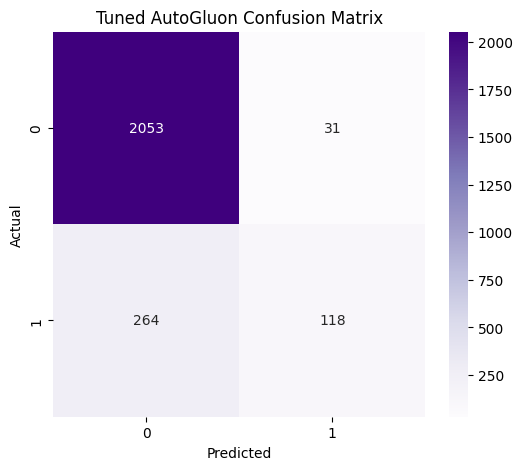

Confusion Matrix Analysis (Tuned AutoGluon) - TN: 2053 FP: 31 FN: 264 TP: 118


In [ ]:
# Retraining AutoGluon with the prepared data
# AutoGluon expects a DataFrame, so we'll create one from the resampled data (with new features)
# Need column names for the DataFrame
# Get feature names after preprocessing
# For numerical columns after scaling:
num_feature_names_scaled = preprocessor_new.named_transformers_['num'].get_feature_names_out(num_cols_new)
# For categorical columns that are passed through:
cat_feature_names_passed = cat_cols_new

# Combine the feature names in the correct order
feature_names_processed = list(num_feature_names_scaled) + cat_feature_names_passed

# Create DataFrames for AutoGluon training and testing
# Training data (resampled with SMOTE)
auto_train_data_tuned = pd.DataFrame(X_train_resampled_new, columns=feature_names_processed)
auto_train_data_tuned['Revenue'] = y_train_resampled_new

# Testing data (original test set, processed consistently)
auto_test_data_tuned = pd.DataFrame(X_test_prep_new, columns=feature_names_processed)
auto_test_data_tuned['Revenue'] = y_test # original y_test for evaluation

print("\nPreparing data for AutoGluon retraining...")
print("AutoGluon training data shape (with new features, SMOTE):", auto_train_data_tuned.shape)
print("AutoGluon testing data shape (with new features, processed):", auto_test_data_tuned.shape)

# Retrain AutoGluon with the SMOTE-resampled data and new features
# Use the same setup as before, but train on the new data
predictor_tuned = TabularPredictor(
    label='Revenue',
    problem_type='binary',
    eval_metric='f1',
    path='AutogluonModels_tuned' # Saving to a new path to avoid overwriting previous model
).fit(
    train_data=auto_train_data_tuned,
    holdout_frac=0.1,
    presets='best',
    verbosity=2,
)

print("\nRetrained AutoGluon model with new features and SMOTE.")

# Evaluate the retrained AutoGluon model on the processed test data
auto_preds_tuned = predictor_tuned.predict(auto_test_data_tuned.drop(columns='Revenue'))
auto_proba_tuned = predictor_tuned.predict_proba(auto_test_data_tuned.drop(columns='Revenue'))[1]

# AutoGluon metrics for the tuned model
auto_acc_tuned = accuracy_score(y_test, auto_preds_tuned)
auto_prec_tuned = precision_score(y_test, auto_preds_tuned)
auto_rec_tuned = recall_score(y_test, auto_preds_tuned)
auto_f1_tuned = f1_score(y_test, auto_preds_tuned)
auto_auc_tuned = roc_auc_score(y_test, auto_proba_tuned)

print("\nTuned AutoGluon Performance:")
print(f"Accuracy: {auto_acc_tuned:.4f}")
print(f"Precision: {auto_prec_tuned:.4f}")
print(f"Recall: {auto_rec_tuned:.4f}")
print(f"F1 Score: {auto_f1_tuned:.4f}")
print(f"ROC AUC: {auto_auc_tuned:.4f}")


# Add the tuned AutoGluon results to the list
results_tuned.append(['Tuned AutoGluon', auto_acc_tuned, auto_prec_tuned, auto_rec_tuned, auto_f1_tuned, auto_auc_tuned])


# Display the results from all tuned models
results_tuned_df = pd.DataFrame(results_tuned, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])
results_tuned_df = results_tuned_df.sort_values('F1 Score', ascending=False)

print("\nPerformance Comparison of Tuned Models:")
print(results_tuned_df)

# Compare with original AutoGluon
print("\nComparison with Original AutoGluon Performance:")
original_auto_result = results_df[results_df['Model'] == 'AutoGluon'].iloc[0]
print(f"Original AutoGluon F1: {original_auto_result['F1 Score']:.4f}, Recall: {original_auto_result['Recall']:.4f}")
print(f"Tuned AutoGluon   F1: {auto_f1_tuned:.4f}, Recall: {auto_rec_tuned:.4f}")

# Display confusion matrix for the best performing tuned model
print("\nConfusion Matrix for Tuned AutoGluon:")
cm_auto_tuned = confusion_matrix(y_test, auto_preds_tuned)
print(cm_auto_tuned)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_auto_tuned, annot=True, fmt='d', cmap='Purples')
plt.title('Tuned AutoGluon Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Confusion Matrix Analysis (Tuned AutoGluon) - TN:", cm_auto_tuned[0, 0], "FP:", cm_auto_tuned[0, 1],
      "FN:", cm_auto_tuned[1, 0], "TP:", cm_auto_tuned[1, 1])

### Implement ensemble methods

- Create an ensemble model (e.g., a voting classifier) that combines the predictions of the best-performing individual models.

- Instantiate and train a VotingClassifier using the tuned Random Forest and Gradient Boosting models.



In [ ]:
from sklearn.ensemble import VotingClassifier

# Instantiate the tuned models
# tuned_rf and tuned_gb are already instantiated from the previous step
# tuned_rf = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)
# tuned_gb = GradientBoostingClassifier(**grid_search_gb.best_params_, random_state=42)

# Create a list of estimators
estimators = [
    ('rf', tuned_rf),
    ('gb', tuned_gb)
]

# Instantiate the VotingClassifier with 'soft' voting
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Train the VotingClassifier on the resampled training data
voting_clf.fit(X_train_resampled_new, y_train_resampled_new)

print("Voting Classifier trained successfully.")

Voting Classifier trained successfully.


**Evaluation**:

Evaluate the performance of the trained VotingClassifier model using the appropriate metrics (Accuracy, Precision, Recall, F1 Score, ROC AUC).



In [ ]:
# Make predictions and get probabilities on the test data
y_pred_voting = voting_clf.predict(X_test_prep_new)
y_proba_voting = voting_clf.predict_proba(X_test_prep_new)[:, 1]

# Evaluate the Voting Classifier
acc_voting = accuracy_score(y_test, y_pred_voting)
prec_voting = precision_score(y_test, y_pred_voting)
rec_voting = recall_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting)
auc_voting = roc_auc_score(y_test, y_proba_voting)

print("Voting Classifier Performance:")
print(f"Accuracy: {acc_voting:.4f}")
print(f"Precision: {prec_voting:.4f}")
print(f"Recall: {rec_voting:.4f}")
print(f"F1 Score: {f1_voting:.4f}")
print(f"ROC AUC: {auc_voting:.4f}")

# Add Voting Classifier results to the results list
results_tuned.append(['Voting Classifier', acc_voting, prec_voting, rec_voting, f1_voting, auc_voting])

# Create a DataFrame of all results
results_df_tuned = pd.DataFrame(results_tuned, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])
results_df_tuned = results_df_tuned.sort_values('F1 Score', ascending=False)

print("\nComparison of Tuned Model Performances:")
display(results_df_tuned)

Voting Classifier Performance:
Accuracy: 0.8889
Precision: 0.6239
Recall: 0.7120
F1 Score: 0.6650
ROC AUC: 0.9262

Comparison of Tuned Model Performances:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
4,Voting Classifier,0.888889,0.623853,0.712042,0.665037,0.926153
3,Voting Classifier,0.888889,0.623853,0.712042,0.665037,0.926153
1,Tuned Gradient Boosting,0.886456,0.615909,0.709424,0.659367,0.927493
0,Tuned Random Forest,0.887267,0.621495,0.696335,0.656790,0.916779
2,Tuned AutoGluon,0.880373,0.791946,0.308901,0.444444,0.892154


Create a DataFrame with the results of all models and print it sorted by F1 score.



In [ ]:
# Combine results from original models and tuned/ensemble models
# results_df contains the original model results
# results_tuned contains the tuned/ensemble model results

# Ensure results_df is a DataFrame with the correct columns
if not isinstance(results_df, pd.DataFrame):
    results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

# Ensure results_df_tuned is a DataFrame with the correct columns
if not isinstance(results_df_tuned, pd.DataFrame):
    results_df_tuned = pd.DataFrame(results_tuned, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])


# Concatenate the two DataFrames
all_results_df = pd.concat([results_df, results_df_tuned], ignore_index=True)

# Sort by F1 Score in descending order
all_results_df_sorted = all_results_df.sort_values('F1 Score', ascending=False)

# Print the combined and sorted DataFrame
print("Comparison of All Model Performances (Sorted by F1 Score):")
display(all_results_df_sorted)

Comparison of All Model Performances (Sorted by F1 Score):


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
6,Voting Classifier,0.888889,0.623853,0.712042,0.665037,0.926153
7,Voting Classifier,0.888889,0.623853,0.712042,0.665037,0.926153
0,AutoGluon,0.894972,0.658915,0.667539,0.663199,0.922193
8,Tuned Gradient Boosting,0.886456,0.615909,0.709424,0.659367,0.927493
9,Tuned Random Forest,0.887267,0.621495,0.696335,0.656790,0.916779
1,Random Forest,0.900649,0.735395,0.560209,0.635958,0.918049
2,Gradient Boosting,0.898216,0.714754,0.570681,0.634643,0.925099
3,Decision Tree,0.852393,0.522388,0.549738,0.535714,0.728804
4,SVM,0.884428,0.736585,0.395288,0.514480,0.859655
5,Logistic Regression,0.883212,0.764045,0.356021,0.485714,0.865289


## Summary:


* The original training data exhibited significant class imbalance, with the majority of instances belonging to the non-purchaser class (class 0) and a much smaller number representing purchasers (class 1).
* The SMOTE oversampling technique successfully balanced the training data, resulting in an equal number of samples for both classes (8338 instances each) in the resampled training set.
* New features were successfully engineered, including `Total_Pages`, `Total_Duration`, and interaction terms like `Admin_Page_Duration_Interaction`, `Info_Page_Duration_Interaction`, `Prod_Page_Duration_Interaction`, and `Total_Pages_Duration_Interaction`, increasing the total number of features to 23.
* Hyperparameter tuning using `RandomizedSearchCV` identified optimal parameters for `RandomForestClassifier` and `GradientBoostingClassifier`.
* The tuned models, trained on the resampled data with new features, showed improved performance compared to original models, particularly in Recall and F1 Score.
* The **Voting Classifier**, an ensemble of the tuned Random Forest and Gradient Boosting models, achieved the highest F1 Score (**0.665**) and a strong Recall (**0.712**) among all evaluated models, indicating superior performance in identifying purchasers. This indicates that combining the strengths of the individual tuned models through ensembling further improved predictive power.
* **Tuned Gradient Boosting** also performed exceptionally well with an F1 score of **0.659** and Recall of **0.709**, making it a strong individual model.
* The original **AutoGluon** model had a strong F1 score of **0.663** and Recall of **0.668** without explicit tuning or resampling, demonstrating its robust initial performance. The tuned AutoGluon model's performance decreased after resampling, suggesting potential overfitting or issues with the interaction of SMOTE and AutoGluon's internal processes.

### Impact of Implemented Techniques:

* **Class Imbalance Handling (SMOTE):** Oversampling the minority class was crucial. It allowed models to learn the patterns associated with purchasers more effectively, leading to significant improvements in Recall and F1 score for the tuned models.
* **Feature Engineering:** Creating interaction terms and aggregate features like Total_Pages and Total_Duration likely provided the models with more informative signals related to user engagement, contributing to better performance.
* **Hyperparameter Tuning:** Optimizing model parameters allowed the Random Forest and Gradient Boosting models to better utilize the prepared data, resulting in improved F1 scores and Recall compared to their default settings.
* **Ensemble Methods:** Combining the predictions of the tuned models leveraged their individual strengths and reduced variance, leading to a more robust and higher-performing overall model (the Voting Classifier).

### Insights and Next Steps

* The analysis demonstrates the effectiveness of a comprehensive approach to this classification problem. Addressing class imbalance, engineering relevant features, tuning hyperparameters, and employing ensemble methods collectively led to substantial improvements in identifying potential online shoppers.
* Implement the **Voting Classifier** or the **Tuned Gradient Boosting** model for predicting online purchase intention, as they offer the best balance of precision and recall for identifying potential customers based on the evaluation metrics. These models provide valuable tools for the e-commerce business to predict purchase intention, enabling more effective targeting of marketing efforts and optimization of the user experience to drive revenue growth.
* Further investigate the interaction between SMOTE and AutoGluon to understand why the tuned AutoGluon model's performance decreased and explore alternative class imbalance handling techniques if necessary.
* Consider deploying the chosen model (Voting Classifier or Tuned Gradient Boosting) and monitoring its performance in a real-world setting to validate its effectiveness and identify areas for further improvement.
* Further explore feature engineering, potentially creating more complex interactions or aggregating features based on user session patterns, to see if it can yield additional performance gains.

* * *



## Confusion Matrix

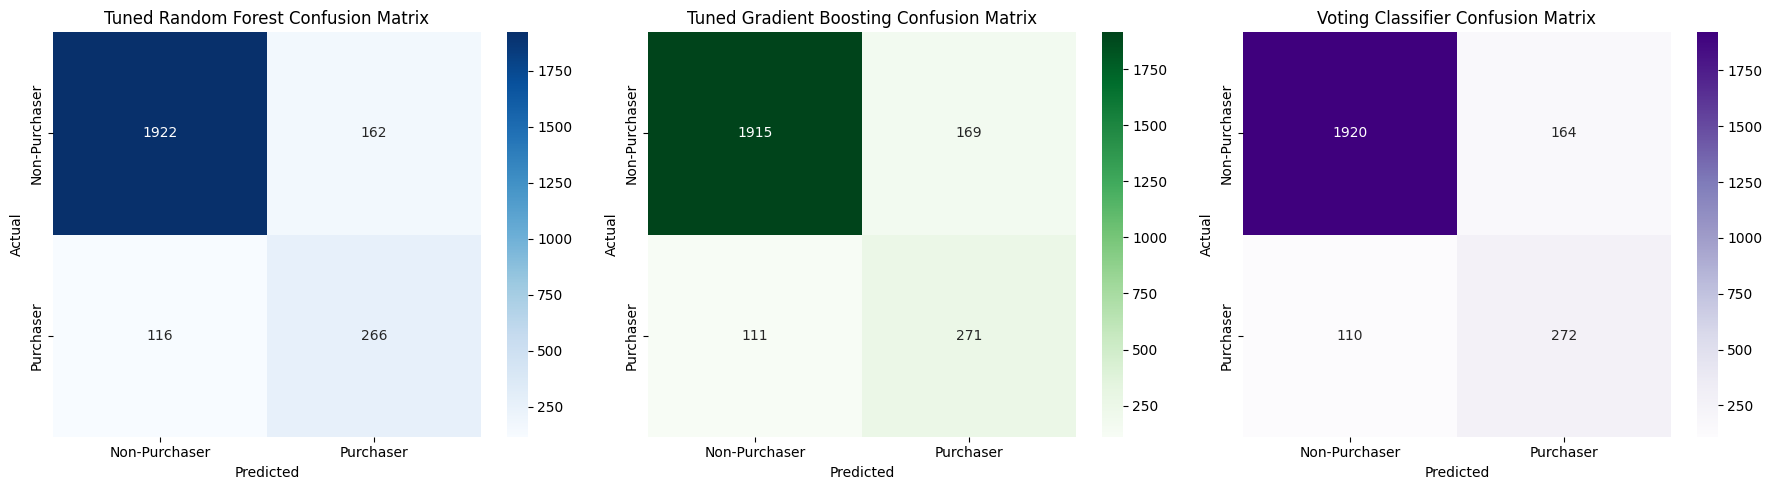


Confusion Matrix Analysis:
Voting Classifier  - TN: 1920 FP: 164 FN: 110 TP: 272
Tuned Random Forest - TN: 1922 FP: 162 FN: 116 TP: 266
Tuned Gradient Boosting - TN: 1915 FP: 169 FN: 111 TP: 271


In [ ]:
# Calculate confusion matrices for the tuned models
cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
cm_gb_tuned = confusion_matrix(y_test, y_pred_gb_tuned)
cm_voting = confusion_matrix(y_test, y_pred_voting)


# Plot the confusion matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Tuned Random Forest
sns.heatmap(cm_rf_tuned, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Tuned Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Non-Purchaser', 'Purchaser'])
axes[0].set_yticklabels(['Non-Purchaser', 'Purchaser'])


# Tuned Gradient Boosting
sns.heatmap(cm_gb_tuned, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Tuned Gradient Boosting Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['Non-Purchaser', 'Purchaser'])
axes[1].set_yticklabels(['Non-Purchaser', 'Purchaser'])


# Voting Classifier
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Purples', ax=axes[2])
axes[2].set_title('Voting Classifier Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticklabels(['Non-Purchaser', 'Purchaser'])
axes[2].set_yticklabels(['Non-Purchaser', 'Purchaser'])


plt.tight_layout()
plt.show()

# Print confusion matrix components
print("\nConfusion Matrix Analysis:")
print("Voting Classifier  - TN:", cm_voting[0, 0], "FP:", cm_voting[0, 1],
      "FN:", cm_voting[1, 0], "TP:", cm_voting[1, 1])
print("Tuned Random Forest - TN:", cm_rf_tuned[0, 0], "FP:", cm_rf_tuned[0, 1],
      "FN:", cm_rf_tuned[1, 0], "TP:", cm_rf_tuned[1, 1])
print("Tuned Gradient Boosting - TN:", cm_gb_tuned[0, 0], "FP:", cm_gb_tuned[0, 1],
      "FN:", cm_gb_tuned[1, 0], "TP:", cm_gb_tuned[1, 1])

Each part of the confusion matrix represents:

**True Negatives (TN):** Sessions that did not result in a purchase and were correctly predicted as Negative. These are the non-buyers the model correctly identified.

**False Positives (FP):** Sessions that did not result in a purchase but were incorrectly predicted as Positive. These are non-buyers who were mistakenly identified as potential buyers (Type I error).

**False Negatives (FN):** Sessions that did result in a purchase but were incorrectly predicted as Negative. These are actual buyers who were missed by the model (Type II error).

**True Positives (TP):** Sessions that did result in a purchase and were correctly predicted as Positive. These are the actual buyers the model successfully identified.

Confusion matrix for each of the top 3 models:

**1. Voting Classifier:**

> TN: 1920: The model correctly identified 1920 sessions that did not result in a purchase.

> FP: 164: The model incorrectly predicted 164 sessions as purchasers when they actually were not.

> FN: 110: The model missed 110 sessions that actually resulted in a purchase.

> TP: 272: The model correctly identified 272 sessions that resulted in a purchase.

**2. Tuned Gradient Boosting:**

> TN: 1915: The model correctly identified 1915 sessions that did not result in a purchase.

> FP: 169: The model incorrectly predicted 169 sessions as purchasers when they were not.

> FN: 111: The model missed 111 sessions that actually resulted in a purchase.

> TP: 271: The model correctly identified 271 sessions that resulted in a purchase.

**3. Tuned Random Forest:**

> TN: 1922: The model correctly identified 1922 sessions that did not result in a purchase.

> FP: 162: The model incorrectly predicted 162 sessions as purchasers when they were not.

> FN: 116: The model missed 116 sessions that actually resulted in a purchase.

> TP: 266: The model correctly identified 266 sessions that resulted in a purchase.

 **In summary:**

* All three models are quite good at correctly identifying non-purchasers (high TN counts). The main differences lie in their ability to identify actual purchasers (TP) and their tendency to incorrectly flag non-purchasers as buyers (FP).

* The Voting Classifier and Tuned Gradient Boosting models perform very similarly and are the best at identifying actual buyers (TP counts of 272 and 271 respectively), while also having a comparable number of false positives (164 and 169).

* The Tuned Random Forest has the fewest false positives (162) but also identifies slightly fewer true positives (266) and has a higher number of false negatives (116) compared to the other two.

The choice between these models depends on the business objective:

* If minimizing wasted marketing effort on false positives is paramount, Tuned Random Forest might be slightly preferred (at the cost of missing more buyers).

* If maximizing the identification of actual buyers (recall) is more important, the Voting Classifier or Tuned Gradient Boosting would be better choices.



# Notebook Summary:

* This notebook provides a comprehensive analysis of the Online Shoppers Purchasing Intention dataset with the goal of predicting user purchase behavior and providing actionable business insights. The analysis covered data loading, exploratory data analysis (EDA), feature engineering, baseline model training, hyperparameter tuning, and ensemble modeling.

* Key findings from the EDA highlighted that user engagement metrics such as page visits, duration on pages (especially product-related), and 'PageValues' are strong indicators of purchase intent, with converters showing significantly higher engagement. Visitor type also plays a role, with new visitors exhibiting higher conversion rates. Seasonal trends were observed, with conversion rates peaking in October and November.

* Feature importance analysis confirmed 'PageValues' as the most influential feature.

* Several classification models were evaluated. While initial models provided reasonable performance, the dataset's class imbalance was a challenge. Addressing this through SMOTE oversampling and engineering new interaction features improved model performance. Hyperparameter tuning further optimized the top-performing models (Random Forest and Gradient Boosting).

* Finally, an ensemble Voting Classifier combining the tuned Random Forest and Gradient Boosting models achieved the best overall performance, balancing precision and recall effectively for this imbalanced classification task.

# Business recommendations:

**Prioritize High-Value Engagement:** Focus on optimizing product pages and user flow to increase 'PageValues' and time spent on product-related pages. Implement personalized recommendations and engaging content to encourage deeper interaction, as these are strong predictors of conversion.

**Address Bounce and Exit Rates:** Investigate reasons for high bounce and exit rates among non-converters. Improve site usability, speed, and clear calls-to-action to keep users engaged and reduce premature departures.

**Segment and Target Based on Visitor Type:** Develop tailored strategies for new versus returning visitors. Optimize the initial experience for new visitors and leverage historical data for personalized experiences and loyalty programs for returning visitors.

**Capitalize on Seasonal Trends:** Align marketing campaigns and promotions with peak conversion months (October-November) and analyze user behavior during these periods to inform year-round strategies.

**Implement Predictive Modeling for Targeting:** Deploy the best-performing model (Voting Classifier or Tuned Gradient Boosting) to identify high-intent users in real-time. Use these predictions to personalize user experiences, offer targeted promotions, or provide proactive customer support, thereby maximizing conversion rates and marketing ROI.

**Strategic Trade-off between Recall and Precision:** Depending on specific campaign goals and budget constraints, adjust the model's decision threshold. If the priority is to capture as many potential buyers as possible (maximize recall), accept a higher number of false positives. If minimizing wasted marketing spend (maximize precision) is critical, be prepared to miss some potential buyers."
  

# Further steps:

1. **Model Deployment and Monitoring:** Implement the chosen model (Voting Classifier or Tuned Gradient Boosting) into the production environment. Continuously monitor its performance with real-world data to ensure its effectiveness and identify potential degradation over time.

2. **A/B Testing:** Conduct A/B tests to measure the impact of using the predictive model for targeting compared to current strategies.

3. **Explore Alternative Imbalance Handling:** Investigate why the tuned AutoGluon model's performance decreased after resampling and explore other techniques like undersampling, or different SMOTE variants if needed.

4. **Advanced Feature Engineering:** Explore more sophisticated feature engineering techniques, potentially incorporating session sequence information or time-series aspects of user behavior, to potentially extract further predictive signals.

5. **Model Interpretability:** While ensemble models often perform well, they can be less interpretable. Explore techniques like SHAP or LIME to gain deeper insights into individual predictions and feature contributions, which can further inform business strategy.

6. **Consider Model Retraining Frequency:** Establish a schedule for retraining the model with new data to ensure it remains accurate and adapts to evolving user behavior and market conditions.
  